In [18]:
import torch.nn as nn
import torch
import pdb

import sys, os
import random
import numpy as np
from shutil import copy
import matplotlib.pyplot as plt
from copy import deepcopy

from omegaconf import OmegaConf
import shutil
import pickle
import random
from tqdm import tqdm
import torch.nn.functional as F
from collections import defaultdict

from skimage.filters import threshold_local

In [2]:
# run_path = '/home/harishbabu/projects/PIPNet/runs/010-CUB-27-imgnet_OOD_cnext26_img=224_nprotos=20'
# run_path = '/home/harishbabu/projects/PIPNet/runs/031-CUB-18-imgnet_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/032-CUB-18-imgnet_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/035-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/043-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = "/home/harishbabu/projects/PIPNet/runs/036-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel_uniformity"
# run_path = "/home/harishbabu/projects/PIPNet/runs/041-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/042-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/044-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20-or-4per-desc_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/046-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=10per-desc_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/047-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=5per-desc_tanh-desc"
# run_path = "/home/harishbabu/projects/PIPNet/runs/048-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=5per-desc_tanh-desc_unit-sphere"
# run_path = "/home/harishbabu/projects/PIPNet/runs/051-CUB-18-imgnet_cnext26_img=224_nprotos=4per-desc_tanh-desc_unit-sphere_AW=5-TW=2-UW=2-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/052-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=4per-desc_tanh-desc_unit-sphere_AW=5-TW=2-UW=2-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/pretraining-check-007-AL=3_UW=3"
# run_path = "/home/harishbabu/projects/PIPNet/runs/pretraining-check-010-no-pretraining"
# run_path = "/home/harishbabu/projects/PIPNet/runs/069-CUB-18_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere_finetune=5_no-meanpool_no-softmax_AW=3-TW=2-UW=3-CW=2_batch=20"
# run_path = "/home/harishbabu/projects/PIPNet/runs/082-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-leaf-desc_unit-sphere_finetune=5_no-meanpool_with-softmax_no-addon-bias_AW=3-TW=2-MMW=2-UW=3-CW=2_mm-loss_batch=48"

# 091 basic gaussian multiplier on stage 4
run_path = "/home/harishbabu/projects/PIPNet/runs/091-CUB-18-imgnet_with-equalize-aug_cnext26_BGM=4|1.0|50_img=224_latent-dim=256_nprotos=4per-leaf-desc_unit-sphere_finetune=5_no-meanpool_with-softmax-tau=0.2_no-addon-bias_AW=3-TW=2-MMW=2-UW=3-CW=2_mm-loss_batch=48"

try:
    sys.path.remove('/home/harishbabu/projects/PIPNet')
except:
    pass
sys.path.insert(0, os.path.join(run_path, 'source_clone'))

In [3]:
from pipnet.pipnet import PIPNet, get_network
from util.log import Log
from util.args import get_args, save_args, get_optimizer_nn
from util.data import get_dataloaders
from util.func import init_weights_xavier
from pipnet.train import train_pipnet, test_pipnet
# from pipnet.test import eval_pipnet, get_thresholds, eval_ood
from util.eval_cub_csv import eval_prototypes_cub_parts_csv, get_topk_cub, get_proto_patches_cub
from util.vis_pipnet import visualize, visualize_topk
from util.visualize_prediction import vis_pred, vis_pred_experiments
from util.node import Node
from util.phylo_utils import construct_phylo_tree, construct_discretized_phylo_tree
from util.func import get_patch_size
from util.data import ModifiedLabelLoader

In [48]:
from PIL import Image
import numpy as np
import pdb

def get_heatmap(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1])))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)


def get_heatmap_with_upscaled_similarity(upscaled_activation, input_image):
    # upscaled_activation -> original values no scaling, 224x224
    
#     image_a = latent_activation.cpu().numpy()
#     image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
#     reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1])))
    
    normalized_heatmap = (upscaled_activation - np.min(upscaled_activation)) / (np.max(upscaled_activation) - np.min(upscaled_activation))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

def get_upscaled_activation_uninterpolated(latent_activation, image_size):
    image_a = latent_activation.cpu().numpy()
    min_image_a = image_a.min()
    max_image_a = image_a.max()
    image_a = (image_a - min_image_a) / (max_image_a - min_image_a)
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((image_size[-1], \
                                                                                            image_size[-2]), \
                                                                                          resample=Image.NEAREST ))
    
    reshaped_image_a = (reshaped_image_a / 255).astype('float16')
    reshaped_image_a = (reshaped_image_a * (max_image_a - min_image_a)) + min_image_a
    return reshaped_image_a

def get_heatmap_uninterpolated(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1]), \
                                                                                          resample=Image.NEAREST ))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

def functional_UnitConv2D(in_features, weight, bias, stride = 1, padding=0):
    # REMOVED .data
    normalized_weight = F.normalize(weight, p=2, dim=(1, 2, 3)) # Normalize the kernels to unit vectors
    normalized_input = F.normalize(in_features, p=2, dim=1) # Normalize the input to unit vectors
    if bias is not None:
        normalized_bias = F.normalize(bias, p=2, dim=0) # Normalize the kernels to unit vectors
    else:
        normalized_bias = None
    return F.conv2d(normalized_input, normalized_weight, normalized_bias, stride=stride, padding=padding)

In [5]:
args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

if args.phylo_config:
    phylo_config = OmegaConf.load(args.phylo_config)

if args.phylo_config:
    # construct the phylo tree
    if phylo_config.phyloDistances_string == 'None':
        if '031' in run_path: # this run uses a different phylogeny file that had an extra root node which is a mistake
            root = construct_phylo_tree('/home/harishbabu/data/phlyogenyCUB/18Species-with-extra-root-node/1_tree-consensus-Hacket-18Species-modified_cub-names_v1.phy')
        else:
            root = construct_phylo_tree(phylo_config.phylogeny_path)
        print('-'*25 + ' No discretization ' + '-'*25)
    else:
        root = construct_discretized_phylo_tree(phylo_config.phylogeny_path, phylo_config.phyloDistances_string)
        print('-'*25 + ' Discretized ' + '-'*25)
else:
    # construct the tree (original hierarchy as described in the paper)
    root = Node("root")
    root.add_children(['animal','vehicle','everyday_object','weapon','scuba_diver'])
    root.add_children_to('animal',['non_primate','primate'])
    root.add_children_to('non_primate',['African_elephant','giant_panda','lion'])
    root.add_children_to('primate',['capuchin','gibbon','orangutan'])
    root.add_children_to('vehicle',['ambulance','pickup','sports_car'])
    root.add_children_to('everyday_object',['laptop','sandal','wine_bottle'])
    root.add_children_to('weapon',['assault_rifle','rifle'])
    # flat root
    # root.add_children(['scuba_diver','African_elephant','giant_panda','lion','capuchin','gibbon','orangutan','ambulance','pickup','sports_car','laptop','sandal','wine_bottle','assault_rifle','rifle'])
root.assign_all_descendents()

exp_no = int(os.path.basename(run_path)[:3])

if exp_no < 77:
    if ('num_protos_per_descendant' in args) and (args.num_protos_per_descendant > 0):
        for node in root.nodes_with_children():
            node.set_num_protos(args.num_protos_per_descendant)
else:
    # update num of protos per node based on num_protos_per_descendant
    if args.num_features == 0 and args.num_protos_per_descendant == 0:
        raise Exception('Either of num_features or num_protos_per_descendant must be greater than zero')
    for node in root.nodes_with_children():
        node.set_num_protos(num_protos_per_descendant=args.num_protos_per_descendant,\
                            min_protos=args.num_features,\
                            split_protos=('protopool' in args) and (args.protopool == 'n'))

------------------------- No discretization -------------------------


In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    device_ids = [torch.cuda.current_device()]
else:
    device = torch.device('cpu')
    device_ids = []

args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

# ckpt_file_name = 'net_overspecific_pruned_replaced_thresh=0.5_last'
ckpt_file_name = 'net_trained_last'
# ckpt_file_name = 'net_trained_10'
# ckpt_file_name = 'net_pretrained'
epoch = ckpt_file_name.split('_')[-1]

ckpt_path = os.path.join(run_path, 'checkpoints', ckpt_file_name)
checkpoint = torch.load(ckpt_path, map_location=device)

if ckpt_file_name != 'net_trained_last':
    print('\n', (10*'-')+'WARNING: Not using the final trained model'+(10*'-'), '\n')

# Obtain the dataset and dataloaders
trainloader, trainloader_pretraining, trainloader_normal, trainloader_normal_augment, projectloader, testloader, test_projectloader, classes = get_dataloaders(args, device)
if len(classes)<=20:
    if args.validation_size == 0.:
        print("Classes: ", testloader.dataset.class_to_idx, flush=True)
    else:
        print("Classes: ", str(classes), flush=True)

def build_net():
    # Create a convolutional network based on arguments and add 1x1 conv layer
    feature_net, add_on_layers, pool_layer, classification_layers, num_prototypes = get_network(len(classes), args, root=root)

    # Create a PIP-Net
    net = PIPNet(num_classes=len(classes),
                        num_prototypes=num_prototypes,
                        feature_net = feature_net,
                        args = args,
                        add_on_layers = add_on_layers,
                        pool_layer = pool_layer,
                        classification_layers = classification_layers,
                        num_parent_nodes = len(root.nodes_with_children()),
                        root = root
                        )
    net = net.to(device=device)
    net = nn.DataParallel(net, device_ids = device_ids)    
    # net.load_state_dict(checkpoint['model_state_dict'],strict=True)
    net.eval()
    
    return net
criterion = nn.NLLLoss(reduction='mean').to(device)



Num classes (k) =  18 ['cub_001_Black_footed_Albatross', 'cub_002_Laysan_Albatross', 'cub_003_Sooty_Albatross', 'cub_004_Groove_billed_Ani', 'cub_023_Brandt_Cormorant'] etc.
Classes:  {'cub_001_Black_footed_Albatross': 0, 'cub_002_Laysan_Albatross': 1, 'cub_003_Sooty_Albatross': 2, 'cub_004_Groove_billed_Ani': 3, 'cub_023_Brandt_Cormorant': 4, 'cub_024_Red_faced_Cormorant': 5, 'cub_025_Pelagic_Cormorant': 6, 'cub_031_Black_billed_Cuckoo': 7, 'cub_032_Mangrove_Cuckoo': 8, 'cub_033_Yellow_billed_Cuckoo': 9, 'cub_045_Northern_Fulmar': 10, 'cub_050_Eared_Grebe': 11, 'cub_051_Horned_Grebe': 12, 'cub_052_Pied_billed_Grebe': 13, 'cub_053_Western_Grebe': 14, 'cub_086_Pacific_Loon': 15, 'cub_100_Brown_Pelican': 16, 'cub_101_White_Pelican': 17}


# Configs

In [7]:
model_stage = 'trained' #'trained', 'pretrained', 'untrained'
# STAGE = 4
# USE_COSINE_SIMILARITY = True # True, False

# print('-*'*10, 'IMPORTANT', '-*'*10)
# if USE_COSINE_SIMILARITY:# Configs
#     print('-*'*10, 'Using COSINE SIMILARITY', '-*'*10)
# else:
#     print('-*'*10, 'Using INNER PRODUCT', '-*'*10)

# Load model

In [8]:


if model_stage == 'trained':
    net = build_net()
    net.load_state_dict(checkpoint['model_state_dict'],strict=True)
elif model_stage == 'pretrained':
    net = build_net()
    # load backbone 'module._net' from checkpoint
    pretrained_ckpt_path = os.path.join(run_path, 'checkpoints', 'net_pretrained')
    pretrained_checkpoint = torch.load(pretrained_ckpt_path, map_location=device)
    filtered_checkpoint_dict = {key:val for key, val in pretrained_checkpoint['model_state_dict'].items() \
                                if key.startswith('module._net')}
    net.load_state_dict(filtered_checkpoint_dict,strict=False) 
    print(f"Backbone loaded", flush=True)
elif model_stage == 'untrained':
    net = build_net()
print(net)
print()# Load model

stage 4
Number of prototypes:  768
----------Prototypes per descendant: 4----------
Assigned 72 protos to node root
Assigned 16 protos to node 052+053
Assigned 56 protos to node 004+086
Assigned 12 protos to node 053+050
Assigned 16 protos to node 004+032
Assigned 40 protos to node 086+045
Assigned 8 protos to node 050+051
Assigned 12 protos to node 032+033
Assigned 36 protos to node 045+101
Assigned 8 protos to node 033+031
Assigned 16 protos to node 045+003
Assigned 20 protos to node 101+023
Assigned 12 protos to node 003+002
Assigned 8 protos to node 101+100
Assigned 12 protos to node 023+025
Assigned 8 protos to node 002+001
Assigned 8 protos to node 025+024
DataParallel(
  (module): PIPNet(
    (_net): ConvNeXt(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
        )
        (1): Sequential(
          (0): CNBlock(
            (bl

In [9]:
softmaxes_shape = None
# Forward one batch through the backbone to get the latent output size
with torch.no_grad():
    xs1, _, _ = next(iter(trainloader))
    xs1 = xs1.to(device)
    hidden_state = net.module._net(xs1)
    wshape = hidden_state.shape[-1]
    args.wshape = wshape #needed for calculating image patch size
    softmaxes_shape = hidden_state.shape
    print("Output shape: ", hidden_state.shape, flush=True)
    print("args.wshape", args.wshape)
    print("softmaxes_shape", softmaxes_shape)    

Output shape:  torch.Size([48, 768, 26, 26])
args.wshape 26
softmaxes_shape torch.Size([48, 768, 26, 26])


In [10]:
from util.data import ModifiedLabelLoader
from collections import defaultdict
import heapq
import pdb
from util.vis_pipnet import get_img_coordinates
import torchvision.transforms as transforms
from PIL import ImageFont, Image, ImageDraw as D
import torchvision
import torch.nn.functional as F

def find_top_percentile_bbox(image, percentile=95):
    threshold = np.percentile(image.flatten(), percentile)
    mask = image >= threshold
    coords = np.argwhere(mask)
    if coords.size == 0:
        return None, None, None, None
    h_min, w_min = coords.min(axis=0)
    h_max, w_max = coords.max(axis=0)
    h_min, h_max, w_min, w_max = map(int, [h_min, h_max, w_min, w_max])
    return h_min, h_max, w_min, w_max

def find_high_activation_crop(activation_map, percentile=95):
    threshold = np.percentile(activation_map, percentile)
    mask = np.ones(activation_map.shape)
    mask[activation_map < threshold] = 0
    lower_y, upper_y, lower_x, upper_x = 0, 0, 0, 0
    for i in range(mask.shape[0]):
        if np.amax(mask[i]) > 0.5:
            lower_y = i
            break
    for i in reversed(range(mask.shape[0])):
        if np.amax(mask[i]) > 0.5:
            upper_y = i
            break
    for j in range(mask.shape[1]):
        if np.amax(mask[:,j]) > 0.5:
            lower_x = j
            break
    for j in reversed(range(mask.shape[1])):
        if np.amax(mask[:,j]) > 0.5:
            upper_x = j
            break
    return lower_y, upper_y+1, lower_x, upper_x+1

def get_upscaled_activation_uninterpolated(latent_activation, image_size):
    # latent_activation -> 1x26x26, image_size -> 3x224x224
    image_a = latent_activation.cpu().numpy()
    min_image_a = image_a.min()
    max_image_a = image_a.max()
    image_a = (image_a - min_image_a) / (max_image_a - min_image_a)
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((image_size[-1], \
                                                                                            image_size[-2]), \
                                                                                          resample=Image.NEAREST ))
    
    reshaped_image_a = (reshaped_image_a / 255).astype('float16')
    reshaped_image_a = (reshaped_image_a * (max_image_a - min_image_a)) + min_image_a
    return reshaped_image_a

def functional_UnitConv2D(in_features, weight, bias, stride = 1, padding=0):
    normalized_weight = F.normalize(weight.data, p=2, dim=(1, 2, 3)) # Normalize the kernels to unit vectors
    normalized_input = F.normalize(in_features, p=2, dim=1) # Normalize the input to unit vectors
    if bias is not None:
        normalized_bias = F.normalize(bias.data, p=2, dim=0) # Normalize the kernels to unit vectors
    else:
        normalized_bias = None
    return F.conv2d(normalized_input, normalized_weight, normalized_bias, stride=stride, padding=padding)

def findCorrespondingToMax(base, target):
    output, indices = F.max_pool2d(base, kernel_size=(26, 26), return_indices=True)# these are logits
    tensor_flattened = target.view(target.shape[0], target.shape[1], -1)
    indices_flattened = indices.view(target.shape[0], target.shape[1], -1)
    corresponding_values_in_target = torch.gather(tensor_flattened, 2, indices_flattened)
    corresponding_values_in_target = corresponding_values_in_target.view(target.shape[0],\
                                     target.shape[1], 1, 1)
    pooled_target = corresponding_values_in_target
    return pooled_target

def customForwardWithCSandSoftmax(net, xs,  inference=False):
    features = net.module._net(xs) 
    proto_features = {}
    proto_features_cs = {}
    proto_features_softmaxed = {}
    pooled = {}
    pooled_cs = {}
    pooled_softmaxed = {}
    out = {}
    for node in net.module.root.nodes_with_children():
        # this may or may not be cosine similarity based on UniConv2D or Conv2d
        proto_features[node.name] = getattr(net.module, '_'+node.name+'_add_on')(features)
        
        #calculating cosine similarity
        prototypes = getattr(net.module, '_'+node.name+'_add_on')
        proto_features_cs[node.name] = functional_UnitConv2D(features, prototypes.weight, prototypes.bias)

        if net.module.args.softmax == 'y':
            softmax_tau = 0.2
            proto_features[node.name] = proto_features[node.name] / softmax_tau
            proto_features_softmaxed[node.name] = net.module._softmax(proto_features[node.name])
            proto_features[node.name] = proto_features_softmaxed[node.name] # will be overwritten if args.multiply_cs_softmax == 'y'
        elif net.module.args.gumbel_softmax == 'y':
            proto_features_softmaxed[node.name] = net.module._gumbel_softmax(proto_features[node.name])
            proto_features[node.name] = proto_features_softmaxed[node.name] # will be overwritten if args.multiply_cs_softmax == 'y'

        if net.module.args.multiply_cs_softmax == 'y':
            proto_features[node.name] = proto_features_cs[node.name] * proto_features_softmaxed[node.name]
        pooled[node.name] = net.module._pool(proto_features[node.name])
        
        # this could be softmax or cosine similarity
        pooled_cs[node.name] = findCorrespondingToMax(base=proto_features[node.name], \
                                                     target=proto_features_cs[node.name])
        
        pooled_softmaxed[node.name] = findCorrespondingToMax(base=proto_features[node.name], \
                                                     target=proto_features_softmaxed[node.name])

        if inference:
            pooled[node.name] = torch.where(pooled[node.name] < 0.1, 0., pooled[node.name])  #during inference, ignore all prototypes that have 0.1 similarity or lower
        out[node.name] = getattr(net.module, '_'+node.name+'_classification')(pooled[node.name]) #shape (bs*2, num_classes) # these are logits

    return features, proto_features, pooled, pooled_cs, pooled_softmaxed, out


# Proto activations on leaf descendents - topk images using either NAIVE-HPIPNET or UNIT-SPACE-PROTOPOOL with HEATMAP

In [11]:
# Proto activations on leaf descendents - topk images

from util.data import ModifiedLabelLoader
from collections import defaultdict
import heapq
import pdb
from util.vis_pipnet import get_img_coordinates
import torchvision.transforms as transforms
from PIL import ImageFont, Image, ImageDraw as D
import torchvision
import torch.nn.functional as F

find_non_descendants = False # True, False # param


topk = 10 # param, args param
save_images = True
font = ImageFont.truetype("arial.ttf", 50)
font2 = ImageFont.truetype("arial.ttf", 20)

def get_heap():
    list_ = []
    heapq.heapify(list_)
    return list_

patchsize, skip = get_patch_size(args)

for node in root.nodes_with_children():
#     if node.name == 'root':
#         continue
    non_leaf_children_names = [child.name for child in node.children if not child.is_leaf()]
    if len(non_leaf_children_names) == 0: # if all the children are leaf nodes then skip this node
        continue

    name2label = projectloader.dataset.class_to_idx # param
    label2name = {label:name for name, label in name2label.items()}
    modifiedLabelLoader = ModifiedLabelLoader(projectloader, node)
    coarse_label2name = modifiedLabelLoader.modifiedlabel2name
    node_label_to_children = {label: name for name, label in node.children_to_labels.items()}
    
    imgs = modifiedLabelLoader.filtered_imgs

    img_iter = tqdm(enumerate(modifiedLabelLoader),
                    total=len(modifiedLabelLoader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

    classification_weights = getattr(net.module, '_'+node.name+'_classification').weight
    
    # maps proto_number -> grand_child_name (or descendant leaf name) -> list of top-k activations
    proto_mean_activations = defaultdict(lambda: defaultdict(get_heap))

    # maps class names to the prototypes that belong to that
    class_and_prototypes = defaultdict(set)

    for i, (xs, orig_y, ys) in img_iter:
        if not find_non_descendants: 
            # do only when finding descendants
            if coarse_label2name[ys.item()] not in non_leaf_children_names:
                continue

        xs, ys = xs.to(device), ys.to(device)

        with torch.no_grad():
            model_output = customForwardWithCSandSoftmax(net, xs, inference=False)
            _, softmaxes, pooled, pooled_ip, pooled_softmax, _ = model_output
#             model_output = net(xs, inference=False)
#             if len(model_output) == 3:
#                 softmaxes, pooled, _ = model_output
#             elif len(model_output) == 4:
#                 _, softmaxes, pooled, _ = model_output
            pooled = pooled[node.name].squeeze(0) 
            pooled_ip = pooled_ip[node.name].squeeze(0) 
            softmaxes = softmaxes[node.name]#.squeeze(0)

            for p in range(pooled.shape[0]): # pooled.shape -> [768] (== num of prototypes)
                c_weight = torch.max(classification_weights[:,p]) # classification_weights[:,p].shape -> [200] (== num of classes)
                relevant_proto_classes = torch.nonzero(classification_weights[:, p] > 1e-3)
                relevant_proto_class_names = [node_label_to_children[class_idx.item()] for class_idx in relevant_proto_classes]
                
                # Take the max per prototype.                             
                max_per_prototype, max_idx_per_prototype = torch.max(softmaxes, dim=0)
                max_per_prototype_h, max_idx_per_prototype_h = torch.max(max_per_prototype, dim=1)
                max_per_prototype_w, max_idx_per_prototype_w = torch.max(max_per_prototype_h, dim=1) #shape (num_prototypes)
                
                h_idx = max_idx_per_prototype_h[p, max_idx_per_prototype_w[p]]
                w_idx = max_idx_per_prototype_w[p]

                if len(relevant_proto_class_names) == 0:
                    continue
                
                if (len(relevant_proto_class_names) == 1) and (relevant_proto_class_names[0] not in non_leaf_children_names):
                    continue
                
                h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(args.image_size, softmaxes.shape, patchsize, skip, h_idx, w_idx)
                latent_activation = softmaxes[:, p, :, :]
                if not find_non_descendants:
                    if (coarse_label2name[ys.item()] in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()][4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), pooled_ip[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation, i))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), pooled_ip[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation, i))
                else:
                    if (coarse_label2name[ys.item()] not in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()][4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), pooled_ip[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation, i))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), pooled_ip[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation, i))
                class_and_prototypes[', '.join(relevant_proto_class_names)].add(p)

    
    print('Node', node.name)
    for child_classname in class_and_prototypes:
        
        print('\t'*1, 'Child:', child_classname)
        for p in class_and_prototypes[child_classname]:
            
            logstr = '\t'*2 + f'Proto:{p} '
            for leaf_descendent in proto_mean_activations[p]:
                mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                num_images = len(proto_mean_activations[p][leaf_descendent])
                logstr += f'{leaf_descendent}:({mean_activation}) '
            print(logstr)
            
            # have this for NON descendants
            if len(proto_mean_activations[p]) == 0:
                continue
            
            if save_images:
                patches = []
                right_descriptions = []
                text_region_width = 3 # 3x the width of a patch
                for leaf_descendent, heap in proto_mean_activations[p].items():
                    heap = sorted(heap)[::-1]
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 2)
                    least_activation = min([round(activation, 2) for activation, *_ in proto_mean_activations[p][leaf_descendent]])
                    most_activation = max([round(activation, 2) for activation, *_ in proto_mean_activations[p][leaf_descendent]])
                    mean_cosine_similarity = round(np.mean([activation_inner_product for _, activation_inner_product, *_ in proto_mean_activations[p][leaf_descendent]]), 2)
                    for ele in heap:
                        activation, activation_inner_product, img_to_open, (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation, img_idx = ele
                        image = transforms.Resize(size=(args.image_size, args.image_size))(Image.open(img_to_open))
                        img_tensor = transforms.ToTensor()(image)#.unsqueeze_(0) #shape (1, 3, h, w)
                        img_tensor_patch = img_tensor[:, h_coor_min:h_coor_max, w_coor_min:w_coor_max]
#                         overlayed_image_np = get_heatmap(latent_activation, img_tensor)
#                         overlayed_image = torch.tensor(overlayed_image_np).permute(2, 0, 1).float() / 255.
#                         patches.append(overlayed_image)
                        
                        overlayed_image_np = get_heatmap(latent_activation, img_tensor)
                        
                        overlayed_image_pil = Image.fromarray(overlayed_image_np)
                        draw = D.Draw(overlayed_image_pil)
                        text = f"{(img_idx, p), round(activation, 2), round(activation_inner_product, 2)}"
#                         text_width, text_height = draw.textsize(text, font2)
                        bbox = draw.textbbox((0, 0), text, font2)
                        text_width = bbox[2] - bbox[0]
                        text_height = bbox[3] - bbox[1]
                        x, y = 224 - text_width - 5, 5  # 10 pixels padding from right
                        draw.text((x, y), text, font=font2, fill=(255, 255, 255))
                        overlayed_image_np = np.array(overlayed_image_pil)
                        
                        overlayed_image = torch.tensor(overlayed_image_np).permute(2, 0, 1).float() / 255.
                        
#                         pdb.set_trace()
                        upscaled_similarity = get_upscaled_activation_uninterpolated(latent_activation, image_size=(args.image_size, args.image_size))
                        h_min, h_max, w_min, w_max = find_top_percentile_bbox(upscaled_similarity)
#                         h_min, h_max, w_min, w_max = find_high_activation_crop(upscaled_similarity)
                        h_min, h_max, w_min, w_max
                        bbox_coords = torch.tensor([[w_min, h_min, w_max, h_max]])
                        overlayed_bb_image = torchvision.utils.draw_bounding_boxes((overlayed_image * 255).type(torch.uint8), \
                                                                                   bbox_coords, colors='red') / 255
                        
#                         plt_image = overlayed_bb_image.permute(1, 2, 0)# should be H, W, C with 0 to 1
#                         plt.imshow(plt_image)
#                         plt.show()
#                         pdb.set_trace()
                        patches.append(overlayed_bb_image)

                    # description on the right hand side
                    text = f'{mean_activation}, {leaf_descendent}'
                    txtimage = Image.new("RGB", (patches[0].shape[-2]*text_region_width,patches[0].shape[-1]), (0, 0, 0))
                    draw = D.Draw(txtimage)
                    draw.text((200, patches[0].shape[1]//2), text, anchor='mm', fill="white", font=font)
                    txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)
                    right_descriptions.append(txttensor)
                
                # weird thing padding should be zero for non descendants else it raises some error
                if find_non_descendants:
                    padding = 0
                else:
                    padding = 1

                grid = torchvision.utils.make_grid(patches, nrow=topk, padding=padding)
                grid_right_descriptions = torchvision.utils.make_grid(right_descriptions, nrow=1, padding=padding)

                # merging right description with the grid of images
                grid = torch.cat([grid, grid_right_descriptions], dim=-1)

                # description on the top
                text = f'Node:{node.name}, p{p}, Child:{child_classname}'
                txtimage = Image.new("RGB", (grid.shape[-1], 224), (0, 0, 0))
                draw = D.Draw(txtimage)
                draw.text((350, patches[0].shape[1]//2), text, anchor='mm', fill="white", font=font)
                txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)

                # merging top description with the grid of images
                grid = torch.cat([grid, txttensor], dim=1)
                
                prefix = 'non_' if find_non_descendants else ''
                os.makedirs(os.path.join(run_path, prefix + f'topk_heatmap_with_idx_ep={epoch}', node.name), exist_ok=True)
                torchvision.utils.save_image(grid, os.path.join(run_path, prefix + f'topk_heatmap_with_idx_ep={epoch}', node.name, f'{child_classname}-p{p}.png'))

print('Done !!!')

KeyboardInterrupt: 

In [12]:
import torch
import matplotlib.pyplot as plt
from util.data import ModifiedLabelLoader
from collections import defaultdict
import heapq
import pdb
from util.vis_pipnet import get_img_coordinates
import torchvision.transforms as transforms
from PIL import Image, ImageDraw as D
import torchvision

img_iter = tqdm(enumerate(projectloader),
                    total=len(projectloader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

# Define your integer values for img_size, softmaxes_shape, patchsize, and skip

# softmaxes_shape = (7, 7)  # Example values, adjust as needed
# patchsize = 32
# skip = 16

img_size = 224
patchsize, skip = get_patch_size(args)

print('patchsize, skip', (patchsize, skip))

# Create a dictionary to store images by class
nodeidx2image = {}        
        
for node in root.nodes_with_children():

    modifiedLabelLoader = ModifiedLabelLoader(projectloader, node)
    
    imgs = modifiedLabelLoader.filtered_imgs

    img_iter = tqdm(enumerate(modifiedLabelLoader),
                    total=len(modifiedLabelLoader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

    for i, (xs, orig_y, ys) in img_iter:
        image = xs[0]
        nodeidx2image[node.name+'-'+str(i)] = image
        
print('Done !!')

patchsize, skip (32, 8)


Done !!


In [13]:
# (Node name, proto num, image idx)
ref_imgs = [
    ('003+002', 10, 8),
    ('003+002', 10, 20),
    ('003+002', 10, 25),
    
    ('004+032', 13, 45), #
    ('004+032', 13, 79), #
    ('004+032', 13, 41), #
    ('004+032', 13, 70),
    ('004+032', 13, 93), # 45, 79, 41, 70
    
    ('004+032', 9, 85),
    ('004+032', 9, 64),
    ('004+032', 9, 82),
    
    ('023+025', 6, 50),
    ('023+025', 6, 44),
    ('023+025', 6, 62),
    
    ('023+025', 7, 51),
    ('023+025', 7, 52),
    ('023+025', 7, 50),
    ('023+025', 7, 82),
    
    ('052+053', 7, 36),
    
    ('045+101', 28, 231),

]

In [14]:
with torch.no_grad():
    ref2img = {} # maps to (latent_activation 26x26, image)
    for ref in ref_imgs:
        node_name, proto_num, img_idx = ref
        image = nodeidx2image[node_name+'-'+str(img_idx)]
        image = image.to(device).unsqueeze(0)
        model_output = customForwardWithCSandSoftmax(net, image, inference=False)
        _, softmaxes, pooled, pooled_ip, pooled_softmax, _ = model_output
        latent_activation = softmaxes[node_name][:, proto_num, :, :]
        ref2img["-".join([str(_) for _ in ref])] = (image, latent_activation)

In [69]:
img_list = []
bbox_list = []
overlayed_img_list = []

font2 = ImageFont.truetype("arial.ttf", 20)

def minmaxscale(tensor):
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())

for key, val in ref2img.items():
    top_description = key
    image, latent_activation = val
    
    print(key)
    
    
#     pdb.set_trace()
    
#     upscaled_similarity = get_upscaled_activation_uninterpolated(latent_activation, \
#                                                                  image_size=(args.image_size, args.image_size))
    
#     overlayed_image_np = get_heatmap(latent_activation, image.squeeze(0))
    
    upscaled_similarity = get_upscaled_activation_uninterpolated(latent_activation, \
                                                                 image_size=(args.image_size, \
                                                                             args.image_size))
    upscaled_similarity = minmaxscale(upscaled_similarity)
#     upscaled_similarity = (upscaled_similarity * 255).astype(np.uint8)
    upscaled_similarity = threshold_local(upscaled_similarity, block_size=15, method='median')
    
    # OVERLAYED IMAGE
    overlayed_image_np = get_heatmap_with_upscaled_similarity(upscaled_similarity, image.squeeze(0))
        
    # BOUNDING BOX METHOD
    h_min, h_max, w_min, w_max = find_top_percentile_bbox(upscaled_similarity ,percentile=97)
    
#     pdb.set_trace()
    
    # text on overlayer image
    overlayed_image_pil = Image.fromarray(overlayed_image_np)
    draw = D.Draw(overlayed_image_pil)
    text = top_description
    bbox = draw.textbbox((0, 0), text, font2)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    x, y = args.image_size - text_width - 5, 5  # 10 pixels padding from right
    draw.text((x, y), text, font=font2, fill=(255, 255, 255))
    overlayed_image_np = np.array(overlayed_image_pil)
    
    # text on image
    # 1x3x224x224 to 224x224x3
    image = image.squeeze(0).permute(1, 2, 0).cpu()
    image = minmaxscale(image)
    image_np = image.numpy()
    image_np = (image_np * 255).astype('uint8')
    image_pil = Image.fromarray(image_np)
    draw = D.Draw(image_pil)
    text = top_description
    bbox = draw.textbbox((0, 0), text, font2)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    x, y = args.image_size - text_width - 5, 5  # 10 pixels padding from right
    draw.text((x, y), text, font=font2, fill=(255, 255, 255))
    image_np = np.array(image_pil)
    
    
    img_list.append(image_np)
    overlayed_img_list.append(overlayed_image_np)
    bbox_list.append((h_min, h_max, w_min, w_max))

003+002-10-8
003+002-10-20


/tmp/ipykernel_5266/463349405.py:58: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  resample=Image.NEAREST ))


003+002-10-25
004+032-13-45
004+032-13-79
004+032-13-41
004+032-13-70
004+032-13-93
004+032-9-85
004+032-9-64
004+032-9-82
023+025-6-50
023+025-6-44
023+025-6-62
023+025-7-51
023+025-7-52
023+025-7-50
023+025-7-82
052+053-7-36
045+101-28-231


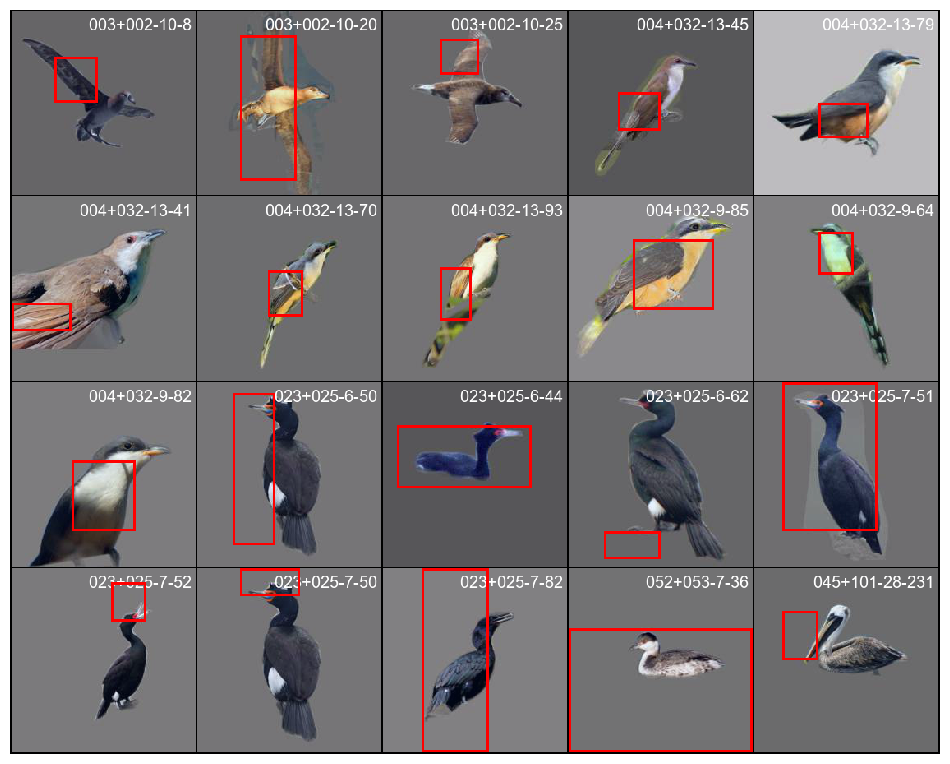

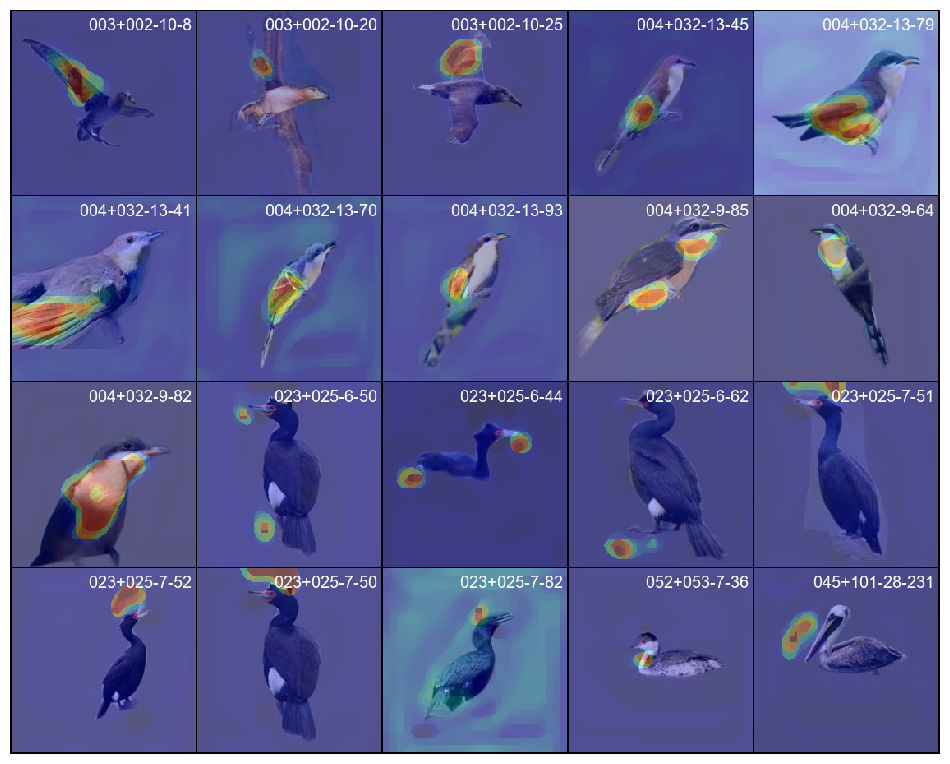

In [70]:
import torch
import torchvision
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

def plot_images_grid(images_list, rows=5, cols=None, figsize=(12, 12)):
    """
    Function to plot images in a grid.
    """
    if cols is None:
        cols = len(images_list) // rows + int(len(images_list) % rows > 0)
    grid = make_grid(images_list, nrow=rows, padding=2)
    plt.figure(figsize=figsize)
    np_grid = grid.numpy()
    plt.imshow(np.transpose(np_grid, (1, 2, 0)), interpolation='nearest')
    plt.axis('off')
    plt.show()

def draw_bounding_boxes(image, bbox):
    """
    Draws a single bounding box on the image.
    """
    # Convert to PIL image for drawing bounding boxes
    pil_image = torchvision.transforms.ToPILImage()(image)
    draw = ImageDraw.Draw(pil_image)
    draw.rectangle(bbox, outline="red", width=3)
    return torchvision.transforms.ToTensor()(pil_image)

# Assuming img_list, bbox_list, and overlayed_img_list are already defined and of the same length
bb_image_list = []
for img, bbox in zip(img_list, bbox_list):
    # Adjust bbox coordinates (x_min, y_min, x_max, y_max)
    adjusted_bbox = [bbox[2], bbox[0], bbox[3], bbox[1]]
    bb_image = draw_bounding_boxes(img, adjusted_bbox)
    bb_image_list.append(bb_image)

# Plotting images with bounding boxes
plot_images_grid(bb_image_list)

overlayed_img_list = [torch.tensor(overlayed_img).permute(2, 0, 1) for overlayed_img in overlayed_img_list]

# Plotting overlayed images
plot_images_grid(overlayed_img_list)


In [67]:
bb_image_list[0].shape

torch.Size([3, 224, 224])

In [68]:
overlayed_img_list[0].shape

torch.Size([224, 224, 3])

In [12]:
from skimage.filter import threshold_otsu, threshold_adaptive

ModuleNotFoundError: No module named 'skimage.filter'

In [4]:
import skimage

In [1]:
import cv2

In [2]:
cv2.adaptiveThreshold

AttributeError: module 'cv2' has no attribute 'adaptiveThreshold'

In [3]:
cv2.ADAPTIVE_THRESH_MEAN_C

AttributeError: module 'cv2' has no attribute 'ADAPTIVE_THRESH_MEAN_C'